Epoch 1/300


/Users/sebastiancondyles/IdeaProjects/AdvAlgoHW4_1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9817 - root_mean_squared_error: 2.2042 - val_loss: 0.4844 - val_root_mean_squared_error: 0.6960
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.5804 - root_mean_squared_error: 0.7609 - val_loss: 0.2774 - val_root_mean_squared_error: 0.5266
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.3652 - root_mean_squared_error: 0.6041 - val_loss: 0.2018 - val_root_mean_squared_error: 0.4492
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.2951 - root_mean_squared_error: 0.5423 - val_loss: 0.1327 - val_root_mean_squared_error: 0.3643
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.2236 - root_mean_squared_error: 0.4726 - val_loss: 0.1105 - val_root_mean_squared_error: 0.3324
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.1757 - root_mean_squared_error: 0.4189 - val_loss: 0.0938 - val_root_mean_squared_error: 0.3063
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss:

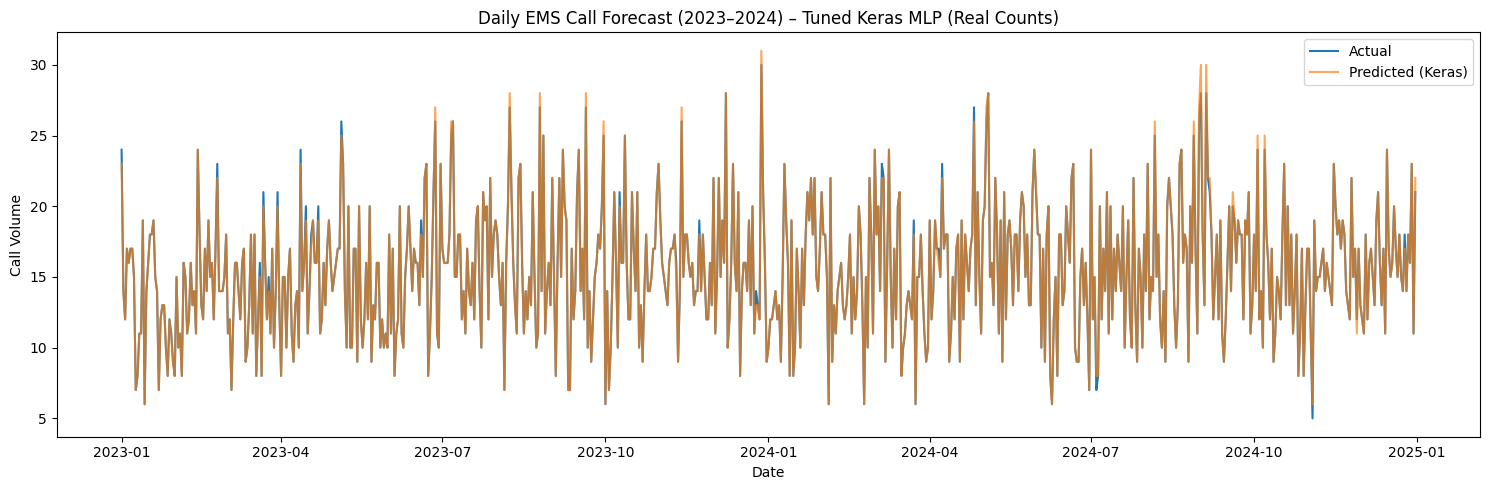

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# --- 1. Load EMS Data ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]
df['date'] = df['CallDateTime'].dt.date
daily = df.groupby('date').size().reset_index(name='call_volume')
daily['date'] = pd.to_datetime(daily['date'])

# --- 2. Calendar Features ---
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['week_of_year'] = daily['date'].dt.isocalendar().week.astype(int)
daily['month'] = daily['date'].dt.month
daily['year'] = daily['date'].dt.year
daily['day_of_year'] = daily['date'].dt.dayofyear
daily['sin_doy'] = np.sin(2 * np.pi * daily['day_of_year'] / 365.25)
daily['cos_doy'] = np.cos(2 * np.pi * daily['day_of_year'] / 365.25)

# --- 3. Lag Features ---
for lag in [1, 2, 3, 7, 14]:
    daily[f'lag_{lag}'] = daily['call_volume'].shift(lag)

daily['rolling_3d'] = daily['call_volume'].rolling(3).mean()
daily['rolling_7d'] = daily['call_volume'].rolling(7).mean()
daily['rolling_30d'] = daily['call_volume'].rolling(30).mean()
daily['same_day_last_week'] = daily['call_volume'].shift(7)
daily['trend_3d'] = daily['rolling_3d'] - daily['rolling_7d']

# --- 4. Holiday/Weekend Flags ---
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=daily['date'].min(), end=daily['date'].max())
daily['is_holiday'] = daily['date'].isin(holidays).astype(int)
daily['is_weekend'] = daily['day_of_week'].isin([5, 6]).astype(int)

# --- 5. Drop missing values ---
daily.dropna(inplace=True)

# --- 6. Define Features ---
features = [
    'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14',
    'rolling_3d', 'rolling_7d', 'rolling_30d',
    'same_day_last_week', 'trend_3d',
    'is_holiday', 'is_weekend',
    'sin_doy', 'cos_doy'
]

# --- 7. Train/Test Split ---
train = daily[daily['date'] < '2023-01-01']
test = daily[daily['date'] >= '2023-01-01']

X_train = train[features]
X_test = test[features]
y_train = train['call_volume']
y_test = test['call_volume']

# --- Same preprocessing as before up to Step 8 ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- Tighter Keras MLP ---
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Predict in log space, convert to real counts ---
preds_log = model.predict(X_test_scaled).flatten()
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = y_test.round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Tuned Keras MLP RMSE (actual calls): {rmse:.2f}")

# --- Plot (real values only) ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'].values, y_test_actual.values, label='Actual')
plt.plot(test['date'].values, preds, label='Predicted (Keras)', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Forecast (2023–2024) – Tuned Keras MLP (Real Counts)')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()

Epoch 1/300
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7760 - root_mean_squared_error: 0.8489 - val_loss: 0.1158 - val_root_mean_squared_error: 0.3402
Epoch 2/300
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 0.1032 - root_mean_squared_error: 0.3208 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1990
Epoch 3/300
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.0576 - root_mean_squared_error: 0.2398 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1649
Epoch 4/300
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.0476 - root_mean_squared_error: 0.2179 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433
Epoch 5/300
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.0379 - root_mean_squared_error: 0.1947 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1324
Epoch 6/300
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 0.0303 - root_mean_squared_error: 0.1740 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 7/300
231/231 ━━━━━━━━━━━━━━━━

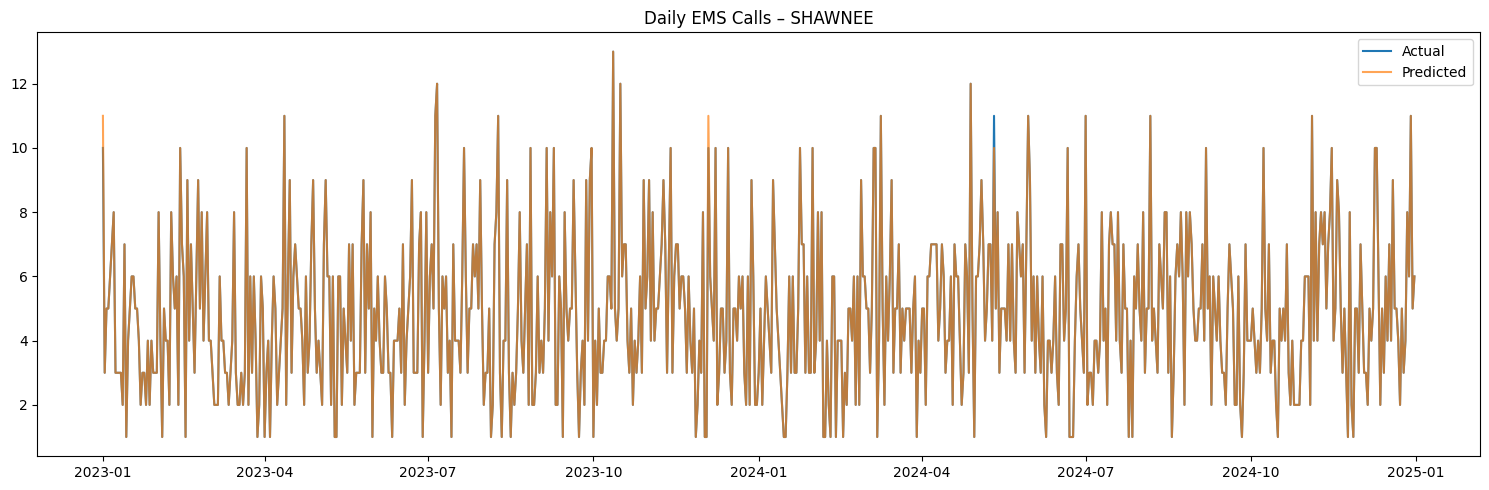

In [2]:
# --- 1. Load Data ---
df = pd.read_csv("../data/clean/calls_by_district.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]
df['date'] = df['CallDateTime'].dt.date

# --- 2. Aggregate per day per district ---
daily = df.groupby(['date', 'NAME']).size().reset_index(name='call_volume')
daily['date'] = pd.to_datetime(daily['date'])

# --- 3. Calendar Features ---
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['week_of_year'] = daily['date'].dt.isocalendar().week.astype(int)
daily['month'] = daily['date'].dt.month
daily['year'] = daily['date'].dt.year
daily['day_of_year'] = daily['date'].dt.dayofyear
daily['sin_doy'] = np.sin(2 * np.pi * daily['day_of_year'] / 365.25)
daily['cos_doy'] = np.cos(2 * np.pi * daily['day_of_year'] / 365.25)

# --- 4. Lag Features (per district) ---
daily = daily.sort_values(['NAME', 'date'])
for lag in [1, 2, 3, 7, 14]:
    daily[f'lag_{lag}'] = daily.groupby('NAME')['call_volume'].shift(lag)

daily['rolling_3d'] = daily.groupby('NAME')['call_volume'].rolling(3).mean().reset_index(level=0, drop=True)
daily['rolling_7d'] = daily.groupby('NAME')['call_volume'].rolling(7).mean().reset_index(level=0, drop=True)
daily['rolling_30d'] = daily.groupby('NAME')['call_volume'].rolling(30).mean().reset_index(level=0, drop=True)
daily['trend_3d'] = daily['rolling_3d'] - daily['rolling_7d']

# --- 5. Holiday/Weekend Flags ---
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=daily['date'].min(), end=daily['date'].max())
daily['is_holiday'] = daily['date'].isin(holidays).astype(int)
daily['is_weekend'] = daily['day_of_week'].isin([5, 6]).astype(int)

# --- 6. Drop missing ---
daily.dropna(inplace=True)

# --- 7. Encode District (NAME) ---
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
daily['district_id'] = le.fit_transform(daily['NAME'])

# --- 8. Features ---
features = [
    'district_id',  # for embedding
    'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14',
    'rolling_3d', 'rolling_7d', 'rolling_30d',
    'trend_3d', 'is_holiday', 'is_weekend',
    'sin_doy', 'cos_doy'
]

# Split
train = daily[daily['date'] < '2023-01-01']
test = daily[daily['date'] >= '2023-01-01']

X_train_num = train[features[1:]]
X_test_num = test[features[1:]]
y_train = train['call_volume']
y_test = test['call_volume']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

# Keep district IDs separate for embeddings
X_train_dist = train['district_id'].values
X_test_dist = test['district_id'].values

# Log transform target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- 9. Keras Model with Embedding for district ---
from tensorflow.keras.layers import Input, Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model

n_districts = daily['district_id'].nunique()
input_num = Input(shape=(X_train_scaled.shape[1],))
input_cat = Input(shape=(1,), dtype='int32')

embed = Embedding(input_dim=n_districts, output_dim=4)(input_cat)
embed_flat = Flatten()(embed)

x = Concatenate()([input_num, embed_flat])
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1)(x)

model = Model(inputs=[input_num, input_cat], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    [X_train_scaled, X_train_dist],
    y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 10. Predictions ---
preds_log = model.predict([X_test_scaled, X_test_dist]).flatten()
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = y_test.round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"District MLP RMSE (actual calls): {rmse:.2f}")

# --- 11. Plot: Show one district at a time (example: SHAWNEE) ---
plot_df = test.copy()
plot_df['preds'] = preds
plot_df['actual'] = y_test_actual

district = "SHAWNEE"
sub = plot_df[plot_df['NAME'] == district]

plt.figure(figsize=(15, 5))
plt.plot(sub['date'], sub['actual'], label='Actual')
plt.plot(sub['date'], sub['preds'], label='Predicted', alpha=0.7)
plt.title(f'Daily EMS Calls – {district}')
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# Create a DataFrame with predictions and actuals per district and day
results_df = test[['date', 'NAME']].copy()
results_df['predicted'] = preds
results_df['actual'] = y_test_actual.values

# Show the first few rows
results_df.head(200)


,date,NAME,predicted,actual
8304,2023-01-01,FRIENDSHIP,12,11
8308,2023-01-02,FRIENDSHIP,4,4
8312,2023-01-03,FRIENDSHIP,1,1
8316,2023-01-04,FRIENDSHIP,3,3
8320,2023-01-05,FRIENDSHIP,1,1
...,...,...,...,...
9063,2023-07-18,FRIENDSHIP,8,8
9067,2023-07-19,FRIENDSHIP,6,6
9071,2023-07-20,FRIENDSHIP,2,2
9075,2023-07-21,FRIENDSHIP,4,4
